In [16]:
# %matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

import climt
from sympl import (
    PlotFunctionMonitor,
    TimeDifferencingWrapper, get_constant
)
import numpy as np
from datetime import timedelta
import pickle
import time
import matplotlib.pyplot as plt
from climt import bolton_q_sat
import gzip
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms

def set_label(fig, ax, label):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily=None,
            bbox=dict(facecolor='1', edgecolor='none', pad=3.0, alpha=0.95))
    
# Plot function definition
def plot_function(fig, state):
    
    fig.set_size_inches(8, 6)
    

    ax = fig.add_subplot(2, 2, 2)
    cs = ax.contourf(state['longitude'][:,30:45],state['latitude'][:,30:45],
    state['air_temperature'][0][:,30:45], levels=16, robust=True, cmap='Reds')
    fig.colorbar(cs, ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')    
#     ax.set_title('Air temperature(K)')
    set_label(fig, ax,'b')
    ax.quiver(state['longitude'][:,30:45], state['latitude'][:,30:45], state['eastward_wind'][0][:,30:45],
              state['northward_wind'][0][:,30:45])
    
    import matplotlib.patches as patches
    from matplotlib.patches import Rectangle
    
    ax.add_patch(Rectangle((84.375, 20), 39.375, 40, fill=True, color='white', alpha=0.3))
    ax.add_patch(Rectangle((84.375, -60), 39.375, 40, fill=True, color='white', alpha=0.3))

    rect = patches.Rectangle((86, 45), 10, 10, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    rect = patches.Rectangle((86+8.5, 40), 10, 10, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    rect = patches.Rectangle((86+2*8.5, 35), 10, 10, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    rect = patches.Rectangle((86+3*8.5, 30), 10, 10, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    
    
    ax = fig.add_subplot(2, 2, 1)
    # cs = ax.contourf(state['latitude'][:,0], range(28),
    # state['air_temperature'].mean(dim='lon'), levels=16)
    cs = ax.contourf(np.broadcast_to(state['latitude'][:,0].values[:], (28, 64)), state['air_pressure'].mean(dim='lon')/100,
    state['air_temperature'].mean(dim='lon'), levels=16, cmap='Reds', robust=True)
    fig.colorbar(cs, ax=ax)
#     ax.set_xlabel('Lat')
    ax.set_ylabel('Air pressure (hPa)')
    ax.invert_yaxis()       
#     ax.set_title('Air temperature(K)')
    set_label(fig, ax,'a')
    
    up=np.max(state['eastward_wind'].mean(dim='lon')).item() 
    down=np.abs(np.min(state['eastward_wind'].mean(dim='lon')).item())
    lim=max(up,down)
    ax = fig.add_subplot(2, 2, 3)
    cs = ax.contourf(np.broadcast_to(state['latitude'][:,0].values[:], (28, 64)), state['air_pressure'].mean(dim='lon')/100,
    state['eastward_wind'].mean(dim='lon'), levels=16, cmap='RdBu_r', robust=True, vmin=-lim, vmax=lim)
    fig.colorbar(cs, ax=ax)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Air pressure (hPa)')
    ax.invert_yaxis()       
#     ax.set_title('Zonal Wind(m/s)')
    set_label(fig, ax,'c')
    
#     up=np.max(state['northward_wind'].mean(dim='lon')).item() 
#     down=np.abs(np.min(state['northward_wind'].mean(dim='lon')).item())
#     lim=max(up,down)
    ax = fig.add_subplot(2, 2, 4)
    ax.contour(np.broadcast_to(state['latitude'][:,0].values[:], (28, 64)), state['air_pressure'].mean(dim='lon')/100,
    state['eastward_wind'].mean(dim='lon'), levels=8, colors='black', robust=True, alpha=0.6, linewidths=0.5)
    cs = ax.contourf(np.broadcast_to(state['latitude'][:,0].values[:], (28, 64)), state['air_pressure'].mean(dim='lon')/100,
    var_mean, levels=16, cmap='Reds', robust=True)
    fig.colorbar(cs, ax=ax)
    ax.set_xlabel('Latitude')
#     ax.set_ylabel('Air pressure (hPa)')
    ax.invert_yaxis()       
#     ax.set_title('Zonal mean variance of meridional Wind(m/s)')
    set_label(fig, ax,'d')

    fig.tight_layout()
    
    plt.savefig('/home/data/lab_abel/Paper1_plots/model_clim.pdf', bbox_inches='tight')

Observable climatology: 288.89469624658443
Average surface temperature: 286.7261924262938


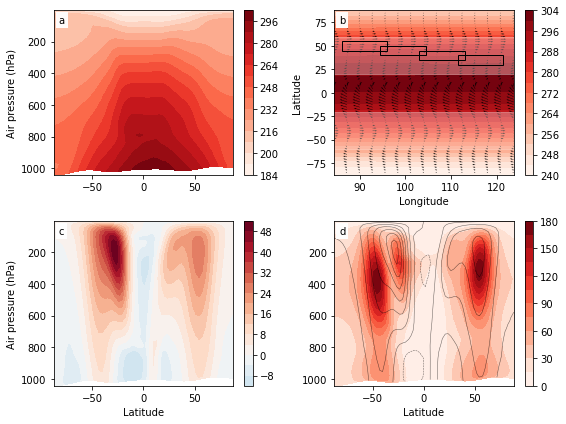

In [17]:
# Set the directory to current directory
# %matplotlib notebook
import os
os.chdir('/home/scratch/Abel_data/GKTL/initial/initial_0.7_6')  

monitor = PlotFunctionMonitor(plot_function, interactive=False)

with gzip.open('new_world_0.7_6', 'rb') as f:
    my_state= pickle.load(f)

with gzip.open('../../../obs_mask10', 'rb') as f:
    mask= pickle.load(f)

lat = np.radians(my_state['latitude'].values[:])
O=my_state['air_temperature'][0].values[:]
print('Observable climatology:',((O*np.cos(lat)*mask).sum())/((np.cos(lat)*mask).sum()))

print('Average surface temperature:',(my_state['surface_temperature'].values[:]*np.cos(lat)).sum()/
(np.cos(lat)).sum())

os.chdir('/home/scratch/Abel_data/GKTL/initial/initial_0.7_6')

M=[]
for i in range(1095):#1095%matplotlib notebookserif
    with gzip.open('state'+str(i+1), 'rb') as f:
        state= pickle.load(f)[0]
    M.append(state['northward_wind'])

M=np.array(M)
var=np.var(M,axis=0)
var_mean=np.mean(var,axis=2)
    
monitor.store(my_state)
# plt.savefig('/home/data/lab_abel/Thesis/clim_base.pdf', bbox_inches='tight')